# RRSG With RIESLING

This Notebook shows how RIESLING can be used to reconstruct the ISMRM Reproducible Research Study Group cg-SENSE Challenge dataset:

O. Maier et al., ‘CG‐SENSE revisited: Results from the first ISMRM reproducibility challenge’, Magnetic Resonance in Medicine, Nov. 2020, doi: 10.1002/mrm.28569.


In [2]:
import os
import sys
import requests

import h5py
import matplotlib.pyplot as plt
import numpy as np
from riesling_rrsg import convert_rrsg
from riesling_plot import plot_trajectory, plot_diff
from types import SimpleNamespace

First, we download the RRSG data from Zenodo

In [3]:
zenodo_files=['rawdata_brain_radial_96proj_12ch.h5', 'rawdata_spiral_ETH.h5']
data_dir = 'rrsg'

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for zf in zenodo_files:
    if not os.path.isfile(f'{data_dir}/{zf}'):
        print(f'Downloading {zf}')
        res = requests.get(f'https://zenodo.org/record/3975887/files/{zf}')
        with open(f'{data_dir}/{zf}', 'wb') as h5f:
            h5f.write(res.content)
    else:
        print(f'Already downloaded {zf}')

Already downloaded rawdata_brain_radial_96proj_12ch.h5
Already downloaded rawdata_spiral_ETH.h5


Then we convert from the RRSG format to the RIESLING format. A utility function is provided in `riesling_rrsg.py` for this. We need to supply the desired matrix and voxel sizes.

In [4]:
matrix_sizes = [[256, 256, 1], [220, 220, 1]]
voxel_sizes = [[0.78, 0.78, 2], [1, 1, 2]]
radial_stem = 'rrsg-radial'
spiral_stem = 'rrsg-spiral'
riesling_files = [f'{radial_stem}.h5', f'{spiral_stem}.h5']
for (inname, mtx, vox, outname) in zip(zenodo_files, matrix_sizes, voxel_sizes, riesling_files):
    convert_rrsg(input_fname=f'{data_dir}/{inname}',
                 output_fname=f'{data_dir}/{outname}',
                 matrix=mtx, voxel_size=vox)

H5 file saved to rrsg/rrsg-radial.h5
H5 file saved to rrsg/rrsg-spiral.h5


## Radial Dataset

First, we plot the trajectory to confirm this is a 2D radial dataset.

(96, 512, 3)


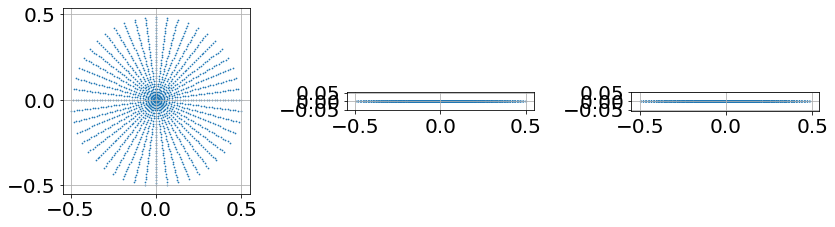

In [5]:
plot_trajectory(f'{data_dir}/{radial_stem}.h5', skip_read=8, skip_spoke=4)

Then we reconstruct the image with the different methods available in `riesling` and compare the outcomes. Note that because we are processing the data in a subdirectory, it is necessary to use the `--out` argument, otherwise the data would be written in the parent directory. We specify the Field-of-View with `--fov` as directed in the paper.

In [6]:
fov = 234
!riesling recon --fov={fov} --os 2.5 {data_dir}/{radial_stem}.h5 --out {data_dir}/{radial_stem}
!riesling tgv --fov={fov} --os 2.5 -i 8 --alpha=1E-6  {data_dir}/{radial_stem}.h5 --out {data_dir}/{radial_stem}
!riesling cg --fov={fov} --os 2.5 {data_dir}/{radial_stem}.h5 --out {data_dir}/{radial_stem}

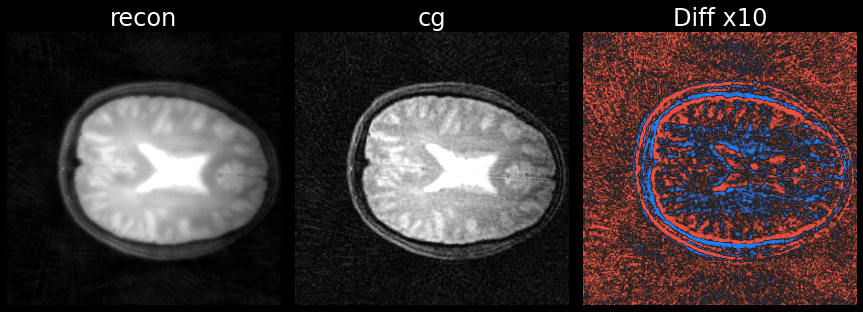

In [7]:
plot_diff(f'{data_dir}/{radial_stem}-recon.h5', f'{data_dir}/{radial_stem}-cg.h5', title1='recon', title2='cg', diffscale=10)

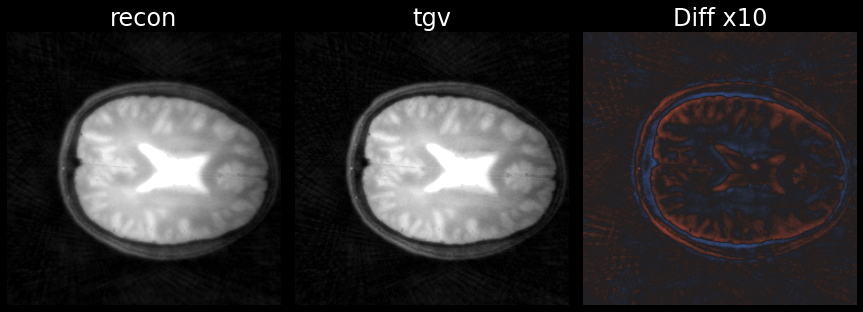

In [8]:
plot_diff(f'{data_dir}/{radial_stem}-recon.h5', f'{data_dir}/{radial_stem}-tgv.h5', title1='recon', title2='tgv', diffscale=10)

## Spiral Dataset

Now we repeat the above for the spiral dataset

(3, 27121, 3)


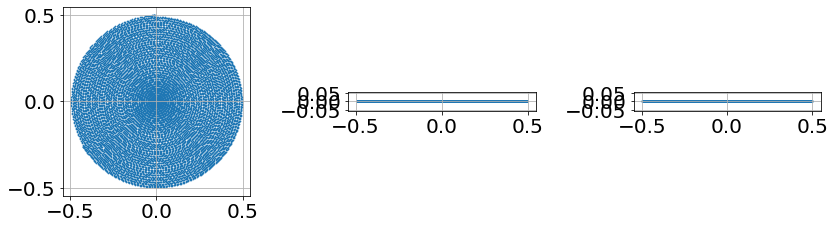

In [9]:
plot_trajectory(f'{data_dir}/{spiral_stem}.h5', skip_read=4, skip_spoke=2)

We reconstruct the spiral data with a Kaiser-Bessel interpolation kernel, which seems to deal better with the particular sampling density.

In [19]:
fov=240
!riesling recon --fov={fov} {data_dir}/{spiral_stem}.h5 --out {data_dir}/{spiral_stem} --kb
!riesling cg --fov={fov} {data_dir}/{spiral_stem}.h5 --out {data_dir}/{spiral_stem} --kb
!riesling tgv --fov={fov} {data_dir}/{spiral_stem}.h5 --out {data_dir}/{spiral_stem} --kb

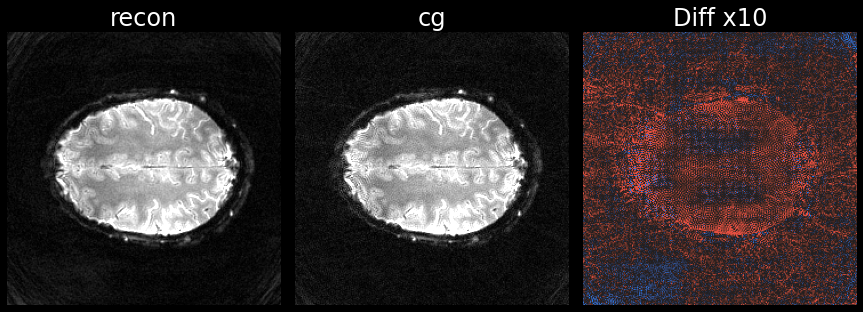

In [20]:
plot_diff(f'{data_dir}/{spiral_stem}-recon.h5', f'{data_dir}/{spiral_stem}-cg.h5', title1='recon', title2='cg', diffscale=10)

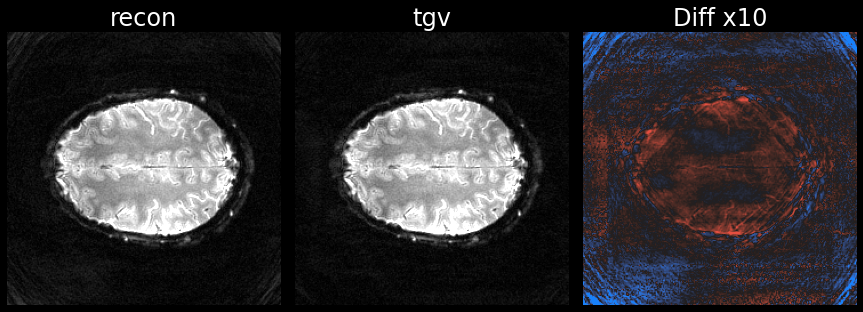

In [21]:
plot_diff(f'{data_dir}/{spiral_stem}-recon.h5', f'{data_dir}/{spiral_stem}-tgv.h5', title1='recon', title2='tgv', diffscale=10)